# [Explortaion 5] Spectrogram classification 모델 구현 😃

이번 프로젝트에서는 음성(오디오)형태의 데이터를 다루는 과정이다.   
텍스트와 달리 오디오는 그 자체만으로도 알고 넘어가야할 것이 많았으며(예를 들면, 파동, 주파수 등..) 이를 전부 이해하고 프로젝트를 진행하는 것은 하루아침에 할 수 있는 일이 아닌것 같아 오디오 파일을 데이터 형식으로 변환하고 활용하는데 집중을 하였다.   
그럼 시이작~!

## 1. 데이터 처리와 분류

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

먼저 데이터셋을 다운받아 준비하고 `np.load`를 통해 로드한다.  
데이터셋에 대한 정보는 아래에 더욱 자세히 설명하였고, 데이터셋 다운로드는 아래에서 진행하였다.   
   
   
   
`$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data`

### 라벨 데이터 처리하기 

In [3]:
#데이터셋 살펴보기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")


Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


데이터셋을 살펴보면, 1초길이의 음성파일 50620개와 8000의 **sample rate**을 가지고 있다.   
여기서 sample rate에 대해 부가적인 설명을 하자면, **샘플링**이라는 단어는 오디오 신호를 디지털 단위로 쪼개기 위해 사용된 단위이다. 즉, 소리를 데이터 단위로 바꾸기 위한 단위를 말한다. 이 데이터셋에서 sample rate은 8000인데, 이는 **1초를 8000의 디지털 단위**로 쪼갰다는 것을 의미한다.   
   
   
데이터셋은 ```wav_vals```와 ```lavel_vals```로 나뉜다. ```wav_vals```는 음성 데이터파일을, ```lavel_vals``` 데이터 파일에 대한 label이다.

아래와 같이 데이터셋을 테스트 해볼 수 있다. label은 yes 가리키고 있고, 음성을 재생해보면 yes라고 정확히 들린다.

In [4]:
#위에서 설명한 데이터가 맞는지 확인해봅시다.
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  42301
Wave data shape :  (8000,)
label :  ['yes']


### sklearn의 train_test_split함수를 이용하여 train, test 분리 

레이블을 학습시키기 위해서는 인덱스 형태로 바꿔줘야한다. 아래와 같이 10개의 레이블에 ```unknown```과 ```silence```를 추가하여 **총 12개**의 인덱스를 각각 추가해준다.

In [5]:
#Label data 처리 / 학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
#Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였습니다.
#int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.

temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data[50000]

11

이제는 ```scikit_learn의 train_test_split```을 활용하여 **train set과 test set을 분리**한다.   
`scikit_learn`을 활용하면 데이터셋의 분리가 아주 쉬워 유용하게 활용할 것 같다.

In [22]:
#학습을 위한 데이터 분리

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                 shuffle=True)
print('train_wav 수 :', len(train_wav))
print('test_wav 수 :', len(test_wav))
print('첫번째 train_wav 길이:', len(train_wav[0]))
print(train_wav)
train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])


train_wav 수 : 45558
test_wav 수 : 5062
첫번째 train_wav 길이: 8000
[[ 1.37812120e-03  2.19695992e-03  8.42016889e-04 ...  8.14145338e-03
   7.97708519e-03  9.92919039e-03]
 [-2.01297953e-04 -2.61025270e-04  7.27146165e-04 ...  6.20668216e-05
   9.06980931e-05  1.10165245e-04]
 [-7.00830370e-02 -1.98620468e-01 -1.60113811e-01 ...  1.63506463e-01
  -6.23556972e-02 -2.37034544e-01]
 ...
 [ 3.85755301e-03  5.49312960e-03  6.72766706e-04 ...  2.55996780e-03
   1.80626509e-03 -1.09540788e-03]
 [-1.06486923e-05 -9.14146804e-05 -2.89382951e-05 ... -2.46212967e-05
  -8.48034397e-05 -2.69717770e-04]
 [ 3.28801014e-03  5.10893622e-03  2.83486501e-04 ...  2.06034514e-03
   1.68294122e-03 -2.31474056e-03]]


분리된 테스트셋과 트레인셋에 대해 자세히 알아보았다.   
먼저, **train_wav**는 총 **45558개**, **test_wav**는 **5062개**로 분리되었다.   
그리고 **train_wav**의 길이는 **8000**개로, 위와 같은 **shape**을 가지고 있다.

# 2. 학습을 위한 하이퍼파라미터 설정

In [24]:
#Hyper-parameters setting
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj58/aiffel/speech_recognition/models/wav'

하이퍼파라미터인 **batch_size**와 **max_epochs**값을 정해준다.   
또, **callback**함수를 위한 **체크포인트**도 설정한다.

# 3. 데이터셋 구성


- tf.data.Dataset을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
    tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.


In [25]:
import librosa
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [26]:
#Data setting
#tf.data.Dataset을 이용해서 데이터셋을 구성하겠습니다. 
#Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다. 

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
import tensorflow as tf
import numpy as np

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)


# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

import librosa
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


위와 같이 ```tf.data.Dataset```을 활용하여 데이터셋을 구성하였다. 자세히 살펴보면 위에 파라미터를 정한 batch_size와 train/test_wav,label등이 들어간다.   
사실 아직 어떻게 ```tf.data.Dataset```을 이용하여 모델을 설정한지 이해가 가지 않아 시간을 가지고 더 공부를 해볼 예정이다.

# 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [27]:
spec_data=[] 
for wav in speech_data["wav_vals"][:10000]: 
    stft = wav2spec(wav)
    spec_data.append(stft)
spec_data = np.array(spec_data)
spec_data.shape

(10000, 130, 126)

2차원 Spectogram을 처리하는 과정에서 많은 오류가 있었다.   
1차원 데이터를 활용해서 2차원 스펙토그램을 만든다는 것은 이해하였는데 이걸 코드로 어떻게 구현할지에 대해서는 전혀 감이 없었다.   
다행히 팀원분들의 도움을 받아 2차원 Spectogram을 구성하였지만 메모리 부족때문인지 커널이 계속 꺼지는 현상이 발생하여 10001개까지로 갯수를 제한하였다.

In [16]:
input_tensor = layers.Input(shape=(sr, 1))


x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

정상적으로 모델을 구성하였고,

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [21]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


체크포인트를 위와 같이 설정하였으며, multi-class classification을 위해 Cross-Entropy loss를 사용하였다. 라고 하는데.. 정확히 어떤 필요에 의해 위와 같은 세팅을 하는지 더 찾아볼 계획이다.

In [22]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.6094
Epoch 00001: val_loss improved from inf to 0.82837, saving model to /home/aiffel-dj58/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 170s 120ms/step - loss: 1.2140 - accuracy: 0.6094 - val_loss: 0.8284 - val_accuracy: 0.7466
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.8064
Epoch 00002: val_loss improved from 0.82837 to 0.52077, saving model to /home/aiffel-dj58/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 173s 121ms/step - loss: 0.6487 - accuracy: 0.8064 - val_loss: 0.5208 - val_accuracy: 0.8426
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.9036
Epoch 00003: val_loss improved from 0.52077 to 0.43105, saving model to /home/aiffel-dj58/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] 

에폭값을 5로 주고 train을 시켰다. epoch당 시간이 너무 오래 걸리다보니 많이 주지 못한게 아쉽다.  
여기서도 시간이 너무 오래 걸리는 오류가 에러가 있었다. 에폭당 8분이 넘게 걸린다고 ETA가 나와있었다. 원인을 찾다보니 랩탑의 배터리 충전이 빠져있어서 성능이 낮아진 것이 원인이었음을 파악했다..

# 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

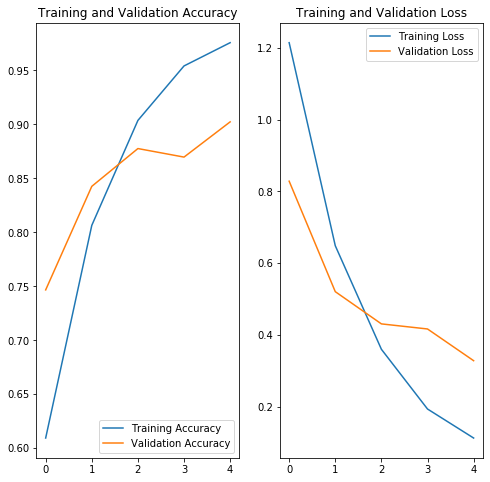

✅


In [23]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

학습 후 matplotlib을 활용하여 그래프를 확인하였다. 에폭값을 10이상으로 놓고 그래프를 확인하면 더 디테일하게 확인할 수 있었을텐데 조금 아쉬운 부분이다. 그래도 어느정도 오버피팅에 대한 부분을 확인할 수 있다.

# 6. Test dataset을 이용해서 모델의 성능을 평가

In [24]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 18s 111ms/step - loss: 0.3288 - accuracy: 0.9022
loss value: 0.329
accuracy value: 90.2213%
✅


진행하면서 아쉬운 부분이 있었음에도 불구하고 정확도는 **90%**가 넘는 정확도를 보여준다. 기대 이상의 성능을 발휘한다.

In [25]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [26]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: go(Correct!)
✅


아주 클리어하게 go라고 선명히 들린다 :)   
이로써 이번 프로젝트는 간단히 마무리 하겠다.

# 회고:  
### 1. **이번 프로젝트에서 어려웠던 점**   
오디오 파일의 데이터 형태에 대한 이해가 가장 어려웠다. 표본화, 양자화, 부호화라는 용어도 그렇고, 주파수와 진폭 등 오디오 데이터 형태에 대해 잘 이해할 수가 없었다. 개인적이 바램으로는 이 노드에 대한 간략한 강의를 해주셨으면 한다. 어찌저찌하여 프로젝트를 완성하고 제출을 할수 있게되었지만 오디오 파일과 형태에 대한 이해를 더 하고 싶다는 생각이 들었다. 
   
### 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
앞서 언급했던 1번과 일맥상통한다. 오디오 데이터가 어떻게 이산화(digital)화 되는지에 이해를 했지만 그 값들이 어떤 의미를 가지는지 내포하는 의미에 대해서는 아직 이해를 하지 못했다. AI에도 자연어 처리, 오디오 등 다양한 분야가 있는데 나는 아직 내가 어떤 분야를 전공으로 공부하려는지 정하지 않았다. 그래서 오디오, 음성에 대한 부분도 열어두고 있다. 혹시 오디오가 내 전문 분야가 될수도 있으니 더 깊이 공부하고 이해하고 싶다.

### 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
1차원 음성데이터를 2차원 spectogram형태로 바꾸는데 오류가 있었다. 먼저는 코드에 대한 오류였고, 두번째는 메모리 부족으로 커널이 꺼지는 오류였다. 코드에 대한 오류는 고민하다가 팀원분의 도움을 받아 해결하였다. 하지만 코드를 실행할 때마다 dead kernel과 함께 인터넷이 꺼지는 현상이 발생하였다. 처음에는 인터넷이 문제인가(우분투에 와이파이 연결이 잘 안된다..) 싶었는데 동일한 증상을 겪는 사람들이 있는 것을 보고 메모리가 문제라는 것을 발견하였다. 해결책으로는 모든 데이터를 사용하지 않고, `[:10000]` 형태로 데이터셋 개수를 제한하니 잘 돌아갔다 :)

   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**    
만약 루브릭 평가 관련 지표를 달성하지 못했다면 그 이유는 아마 3번에서 언급했던 2차원 spectogram으로 데이터를 변환하는데 이유가 있었을 것이라 생각한다. 사실 1,2,3,4번 모두 비슷하고 연관된 질문이라 생각하는데, 그 원인을 생각해보면 자기역량의 부족으로 노드에 대한 전체적인 이해가 부족하여 발생하는 것으로 생각한다.
   
### 5. **자기 다짐**   
노드와 프로젝트를 진행할 수록 내가 발전하고 있음을 느낀다. 물론 지금도 무지무지 어렵지만 처음에 비해 많이 배웠고 발전했다. Aiffel 덕분에 다양한 경험을 하는것 같아 감사한 마음이다.(혼자 공부했다면 이렇게 많은 양의 데이터를 학습하지는 못했을 것이다.)   
앞으로의 다짐은, 인공지능과 관련된 책을 구매하여 아침시간을 활용하여 학습할 예정이다. 파이썬을 공부하고 노드를 복습하는 것도 좋지만 인공지능에 대한 깊은 이해를 가져야 나중에 있을 다양한 노드와 팀프로젝트에서 아이디어와 진행방향에 대해 얘기할 수 있을것 같다.

   